# Analysing accuracy of robust and non-robust models
## Cross Comparison

In [1]:
class CrossAnalysisModule:
    """ Module for easy analysis of details.log json file and rgb images """

    def __init__(self):
        self.file_locations = {}
        self.dfs = {}
        self.varyingVariables = []
        self.columns = []
        self.combinedDf = None

    def addJsonFile(self, file_location, file_name, df_name):
        """ Add a new json to the list of jsons"""
        self.file_locations[df_name] = file_location
        self.dfs[df_name] = self._loadDetailsJson(file_location, file_name)
        if (len(self.varyingVariables)==0):
            self.varyingVariables = self._outputVaryingVariables(df_name)
            self.columns = self.dfs[df_name].columns
        else: #check that they all share the same varying variable as the first
            assert self.varyingVariables == self._outputVaryingVariables(df_name)
            assert self.columns.tolist() == self.dfs[df_name].columns.tolist()
        print(df_name, "has been added to the list of dataframes.")

    def _loadDetailsJson(self, file_location, file_name):
        """ load json detail.log """
        import pandas as pd 
        import numpy as np
        import json
        import os
        class_map = json.load(open(os.path.join(file_location, 'class_maps.json')))
        df = pd.DataFrame.from_records(list(map(json.loads, open(os.path.join(file_location, file_name)).readlines())))
        df = df.drop('render_args', axis=1).join(pd.DataFrame(df.render_args.values.tolist()))
        df['prediction'] = df['prediction'].apply(lambda x: class_map[x[0]])
        df['is_correct'] = (df['is_correct'] == 'True') 
        return df
    
    def _outputVaryingVariables(self, df_name):
        """ Get list of dependent variables """
        varying_variables = []
        #ignore columns 0-3 ('is_correct', 'loss', 'prediction', 'id')
        for colname in self.dfs[df_name].columns[4:]:
            if (self.dfs[df_name][colname].dtype == "object"): # if it is not numeric
                if (self.dfs[df_name][colname].nunique() > 1):
                    varying_variables.append(colname)
            else: # if it is numeric
                if (self.dfs[df_name][colname].var() > 0.0001): 
                    varying_variables.append(colname)
        return varying_variables

    def overallAccuracy(self):
        """ Accuracy across all variables """
        import pandas as pd
        columns = []
        accuracies = []
        for key, value in self.dfs.items():
            columns.append(key)
            accuracies.append(value['is_correct'].mean())
        df = pd.DataFrame([accuracies],columns=columns, index=["Accuracy"])
        return df
    
    def variableSettingAccuracies(self, variable_name):
        """ Accuracy on one variable, across different values """
        returned_df = None
        if (variable_name in self.varyingVariables):
            for key, value in self.dfs.items():
                temp = value.groupby(variable_name).agg(
                        accuracy=('is_correct', 'mean'))
                temp.rename(columns={"accuracy":("acc_"+key)}, inplace=True)
                if (returned_df is None):
                    returned_df=temp
                else:
                    returned_df = returned_df.join(temp)
            returned_df.sort_index(inplace=True)
            return returned_df
        else:
            print("Variable name either does not exist in the dataframe or remains constant through the experiment")
            print("Valid Variable Entries: "+ str(self.varyingVariables))
            print("To get overall accuracy use .overallAccuracy()")

    def getCombinedDf(self):
        import pandas as pd
        if (self.combinedDf is None): 
            combinedDf = None
            important_columns = ['is_correct', 'loss', 'prediction', 'id']
            joining_columns = important_columns.copy()
            joining_columns.extend(self.varyingVariables)
            other_columns = list(set(self.columns) - set(joining_columns))
            for key, value in self.dfs.items():
                if (combinedDf is None): #first df
                    impt = value[important_columns]
                    impt.columns = [(str(col)+"_"+key) for col in impt.columns]
                    combinedDf = pd.concat([impt, value[self.varyingVariables]], axis=1)
                else: #all other df
                    impt = value[important_columns]
                    impt.columns = [(str(col)+"_"+key) for col in impt.columns]
                    concat = pd.concat([impt, value[self.varyingVariables]], axis=1)
                    combinedDf=combinedDf.merge(concat, how='inner', on=self.varyingVariables)
            combinedDf = pd.concat([combinedDf, next(iter(self.dfs.values()))[other_columns]], axis=1)
            self.combinedDf = combinedDf.sort_index(axis=1)
            return self.combinedDf
        else:
            return self.combinedDf
        

    def _filterImageIds(self, filter_input, df_name):
        """
        Get list of ids of images that pass through the filters

        Filter_input should be in this format (inclusive of edges):

            filter_input = { 
                'HazeControl.haze_fac' : 0,
                'OrbitingCameraControl.theta': (0, 1.57),
                'RainControl.n_layers_of_rain': (0, 3),
                'SunControl.elevation': 0
            }
            
        """
        filtered_df = self.dfs[df_name].copy()
        for key, value in filter_input.items():
            if (type(value) is tuple):
                filtered_df = filtered_df.loc[(filtered_df[key]<=value[1]) & (filtered_df[key]>=value[0])]
            else:
                filtered_df = filtered_df.loc[filtered_df[key]==value]
        return filtered_df['id'].tolist()

    def _getImageLabel(self, image_id, displayed_values, df_name):
        """ Get label of an image """
        dictionaryToDisplay = self.dfs[df_name][self.dfs[df_name]['id']==image_id][displayed_values].to_dict('records')[0]
        label = ""
        for key, value in dictionaryToDisplay.items():
            if (isinstance(value, float)):
                value = round(value, 3)
            label += str(key)+": "+ str(value)+"\n"
        return label
    
    def _getImageCorrect(self, image_id, image_df, df_name):
        """ Find out if image was correctly predicted by the model. """
        import pandas as pd 
        combinedDf = self.getCombinedDf()
        return combinedDf[combinedDf[("id_"+image_df)]==image_id]['is_correct_'+df_name].bool()

    def _getImagePrediction(self, image_id, image_df, df_name):
        """ Find out if image was correctly predicted by the model. """
        import pandas as pd 
        combinedDf = self.getCombinedDf()
        return combinedDf[combinedDf[("id_"+image_df)]==image_id]['prediction_'+df_name].to_string(index=False)

    def getFilteredImages(self, filter_input, image_df,columns=4, displayed_values=[]):
        """ Display Filtered Images """
        from math import ceil
        import matplotlib.pyplot as plt
        from matplotlib.image import imread
        import os

        #ensure that columns in displayed_values can be found in the dataframe
        if (not (all(elem in self.columns for elem in displayed_values))):
            print("Not all columns in display_values are in the dataframe")
            return
        elif (len(displayed_values)==0): #if no values entered for displayed_values
            displayed_values=self.varyingVariables
        
        #ensure that we are filtering by existent columns in the dataframe
        if (not (all(elem in self.columns for elem in filter_input))):
            print("Not all columns in filter_input are in the dataframe")
            return

        # Get number of rows
        image_ids = self._filterImageIds(filter_input, image_df)
        num_images = len(image_ids)
        rows = ceil(num_images/columns)

        #if there are no images
        if (len(image_ids)<=0):
            print("There are no images.")
            return

        #if there are images

        #Get figure height
        figure_width = 20
        size_of_each_image = figure_width/columns
        size_of_each_line_in_label = 0.5
        number_of_displayed_values = len(displayed_values)
        size_of_image_label = size_of_each_image + size_of_each_line_in_label*number_of_displayed_values 
        figure_height = rows * size_of_image_label

        image_location = os.path.join(self.file_locations[image_df], 'images')
        #plot images
        plt.figure(figsize=(figure_width, figure_height))
        for i, image_id in enumerate(image_ids):
            image_filename = os.path.join(image_location, (image_id+"_rgb.png"))
            ax = plt.subplot(rows, columns, i + 1)
            plt.title(self._getImageLabel(image_id, displayed_values, image_df))
            
            for i, key in enumerate(self.dfs.keys()):
                color = "green" if self._getImageCorrect(image_id, image_df, key) else "red"
                ax.text(9 , 17+i*20, str(self._getImagePrediction(image_id, image_df, key)),color=color,
                    bbox={'facecolor': 'white', 'alpha': 1, 'pad': 4})
            plt.imshow(imread(image_filename))
        plt.show()

In [3]:
analysis = CrossAnalysisModule()
analysis.addJsonFile("../non_robust/results", "details_mug.log", "non_rob")
analysis.addJsonFile("../robust/results", "details_mug_l2_3_0.log", "l2_3_0")
analysis.addJsonFile("../robust/results", "details_mug_linf_4.log", "linf_4")
analysis.addJsonFile("../robust/results", "details_mug_linf_8.log", "linf_8")

non_rob has been added to the list of dataframes.
l2_3_0 has been added to the list of dataframes.
linf_4 has been added to the list of dataframes.
linf_8 has been added to the list of dataframes.


In [4]:
analysis.varyingVariables

['OrbitingCameraControl.phi', 'OrbitingCameraControl.theta']

In [5]:
analysis.overallAccuracy().to_csv("overall_accuracy.csv")
analysis.overallAccuracy()

,non_rob,l2_3_0,linf_4,linf_8
Accuracy,0.14,0.02,0.24,0.3


In [6]:
analysis.variableSettingAccuracies("OrbitingCameraControl.phi").to_csv("varying_phi.csv")
analysis.variableSettingAccuracies("OrbitingCameraControl.phi")

,acc_non_rob,acc_l2_3_0,acc_linf_4,acc_linf_8
OrbitingCameraControl.phi,,,,
0.000000,0.0,0.0,0.0,0.0
0.174444,0.0,0.0,0.0,0.0
0.348889,0.0,0.0,0.1,0.1
0.523333,0.0,0.0,0.0,0.5
0.697778,0.2,0.0,0.3,0.3
0.872222,0.2,0.0,0.4,0.4
1.046667,0.1,0.1,0.4,0.6
1.221111,0.2,0.0,0.4,0.3
1.395556,0.3,0.0,0.4,0.4


In [7]:
analysis.variableSettingAccuracies("OrbitingCameraControl.theta").to_csv("varying_theta.csv")
analysis.variableSettingAccuracies("OrbitingCameraControl.theta")

,acc_non_rob,acc_l2_3_0,acc_linf_4,acc_linf_8
OrbitingCameraControl.theta,,,,
-3.140000,0.0,0.0,0.0,0.1
-2.442222,0.0,0.0,0.0,0.1
-1.744444,0.3,0.1,0.6,0.7
-1.046667,0.5,0.1,0.6,0.7
-0.348889,0.0,0.0,0.0,0.0
0.348889,0.0,0.0,0.0,0.0
1.046667,0.5,0.0,0.7,0.7
1.744444,0.1,0.0,0.5,0.5
2.442222,0.0,0.0,0.0,0.1


In [8]:
analysis.getCombinedDf().to_csv("merged_df.csv")
analysis.getCombinedDf().head()

,OrbitingCameraControl.object_x,OrbitingCameraControl.object_y,OrbitingCameraControl.object_z,OrbitingCameraControl.phi,OrbitingCameraControl.radius,OrbitingCameraControl.theta,OrientationControl.rotation_x,OrientationControl.rotation_y,OrientationControl.rotation_z,SunControl.air,...,loss_l2_3_0,loss_linf_4,loss_linf_8,loss_non_rob,model,output_type,prediction_l2_3_0,prediction_linf_4,prediction_linf_8,prediction_non_rob
0,-0.5,0,0.268,0.0,0.3,-3.140000,-1.57,0.0,0.0,3.0,...,5.72372,4.518351,5.504456,4.3185015,025_mug.blend,classes,birdhouse,birdhouse,birdhouse,"plunger, plumber""s helper"
1,-0.5,0,0.268,0.0,0.3,-2.442222,-1.57,0.0,0.0,3.0,...,4.581645,2.8384335,4.108287,2.6451116,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,nipple
2,-0.5,0,0.268,0.0,0.3,-1.744444,-1.57,0.0,0.0,3.0,...,3.9022677,2.6945982,3.5215304,3.5791934,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,nipple
3,-0.5,0,0.268,0.0,0.3,-1.046667,-1.57,0.0,0.0,3.0,...,4.289319,2.87723,4.395323,2.648676,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,pill bottle
4,-0.5,0,0.268,0.0,0.3,-0.348889,-1.57,0.0,0.0,3.0,...,4.5773854,3.4605093,4.410081,3.2099,025_mug.blend,classes,"flatworm, platyhelminth",birdhouse,birdhouse,pill bottle


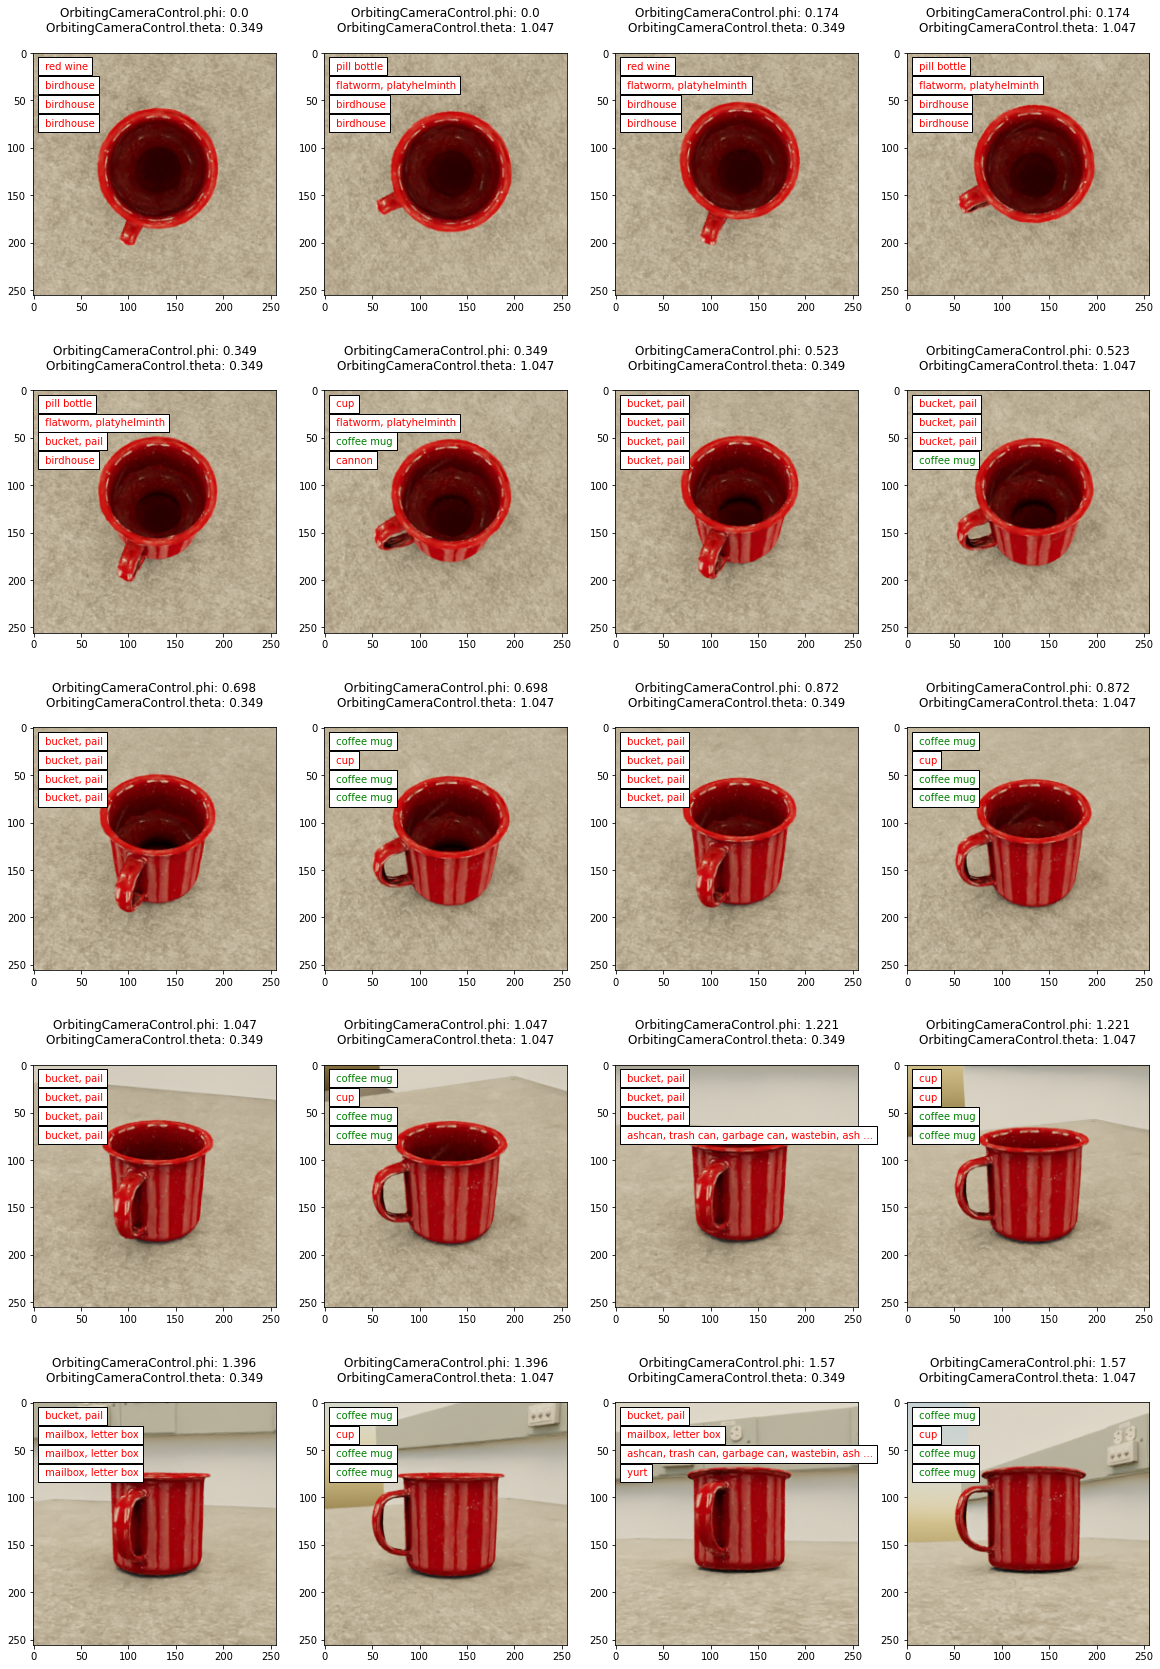

In [10]:
filter_input = { #inclusive of edges
        "OrbitingCameraControl.phi": (0,1.57),
        "OrbitingCameraControl.theta": (0,1.57)
    }
analysis.getFilteredImages(filter_input,"non_rob")